<a href="https://colab.research.google.com/github/ChristopheGraveline064/CDA_mesurement/blob/main/cda_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os

datapath = '/content/drive/MyDrive/aerostick_data/'
df_feature_file = {}
df_target_file = {}

# Load CSV
for filename in os.listdir(datapath):
  #N.B details = features when naming files
  if filename.endswith('.csv') and filename.startswith('tmp-det_AI'):
    print(f'load {filename}')
    df_feature = pd.read_csv(os.path.join(datapath, filename))
    df_feature_file[filename] = df_feature
    print(df_feature.shape)

#TODO the file may or may not have a header
for filename in os.listdir(datapath):
  if filename.endswith('.csv') and filename.startswith('tmp-sum_AI'):
    print(f'load {filename}')
    df_target =  pd.read_csv(os.path.join(datapath, filename), header=None) #Target files do no countain a header
    #Drop the fist two columns that contains index and test name
    df_target = df_target.drop(columns=[df_target.columns[0],df_target.columns[1]])
    df_target_file[filename] = df_target
    print(df_target.shape)

#TODO Drop non-feature columns if needed
#df_target = df_target.drop(columns=[df_target.columns[0],df_target.columns[1]]) # Drop the first column by index


load tmp-det_AI1__=TireTest_Sat Jul 26 083913 2025.csv
(3117, 6)
load tmp-det_AI2__=TireTest_Fri Jul 25 052355 2025.csv
(2797, 6)
load tmp-det_AI3__=TireTest_Tue Jul 22 094322 2025.csv
(3770, 6)
load tmp-det_AI4__=TireTest_Mon Jul 21 095619 2025.csv
(3629, 6)
load tmp-sum_AI1__=TireTest_Sat Jul 26 083913 2025.csv
(30, 5)
load tmp-sum_AI2__=TireTest_Fri Jul 25 052355 2025.csv
(30, 5)
load tmp-sum_AI3__=TireTest_Tue Jul 22 094322 2025.csv
(35, 5)
load tmp-sum_AI4__=TireTest_Mon Jul 21 095619 2025.csv
(30, 5)


#Data Processing

In [4]:
import tensorflow as tf
import numpy as np
import re

features = []
targets = []

target_column = -1  # Assuming this is where your target/label is in cda

for file_name, target_df in df_target_file.items():
  print(f'Process: {file_name}')
  file_tag = re.search(r"AI(\d+)", file_name)

  cda = target_df.values.astype(np.float32)

  #extract the corresponding features file
  if file_tag:
    ai_number = file_tag.group(1)  # Extract the number after AI
    # Reconstruct the matching key for sum_dict
    for feat_key in df_feature_file.keys():
      if re.search(fr"det_AI{ai_number}(?!\d)", feat_key):  # \b ensures 'AI7' doesn't match 'AI70'
        print(f"Found: {feat_key}")
        data = df_feature_file[feat_key].values.astype(np.float32)

  for i in range(len(cda)):
      # Extract the label
      label = cda[i, target_column]

      # Extract the variable-length sequence (rows from data)
      #TODO the number of column used may change
      seq1 = data[int(cda[i, 0]):int(cda[i, 1]), 2:]  # skip column 0, use all others
      seq2 = data[int(cda[i, 2]):int(cda[i, 3]), 2:]
      sequence = np.concatenate([seq1, seq2], axis=0)

      features.append(sequence)  # variable-length 2D array
      targets.append(label)


# Convert features to a RaggedTensor
ragged_features = tf.ragged.constant(features, dtype=tf.float32)

# Convert targets to a normal tensor
targets = tf.convert_to_tensor(targets, dtype=tf.float32)



Process: tmp-sum_AI1__=TireTest_Sat Jul 26 083913 2025.csv
Found: tmp-det_AI1__=TireTest_Sat Jul 26 083913 2025.csv
Process: tmp-sum_AI2__=TireTest_Fri Jul 25 052355 2025.csv
Found: tmp-det_AI2__=TireTest_Fri Jul 25 052355 2025.csv
Process: tmp-sum_AI3__=TireTest_Tue Jul 22 094322 2025.csv
Found: tmp-det_AI3__=TireTest_Tue Jul 22 094322 2025.csv
Process: tmp-sum_AI4__=TireTest_Mon Jul 21 095619 2025.csv
Found: tmp-det_AI4__=TireTest_Mon Jul 21 095619 2025.csv


In [5]:
flatten = False #use when using XGBoost

# Pad the ragged features
padded_features = ragged_features.to_tensor(default_value=0.0)

#convert  to numpy
padded_features_np = padded_features.numpy()
targets_np = targets.numpy()
if flatten:
  padded_features_np = padded_features_np.reshape(125, 295 * 4)

print(f"Sequances dim: {padded_features_np.shape}")
print(f"Target dim:{targets_np.shape}")



Sequances dim: (125, 295, 4)
Target dim:(125,)


In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_features_np, targets_np, test_size=0.2, random_state=42)

#X_train = X_train[:10]
#y_train = y_train[:10]

print(f"X_train dim: {X_train.shape}")
print(f"y_train dim: {y_train.shape}")

X_train dim: (100, 295, 4)
y_train dim: (100,)


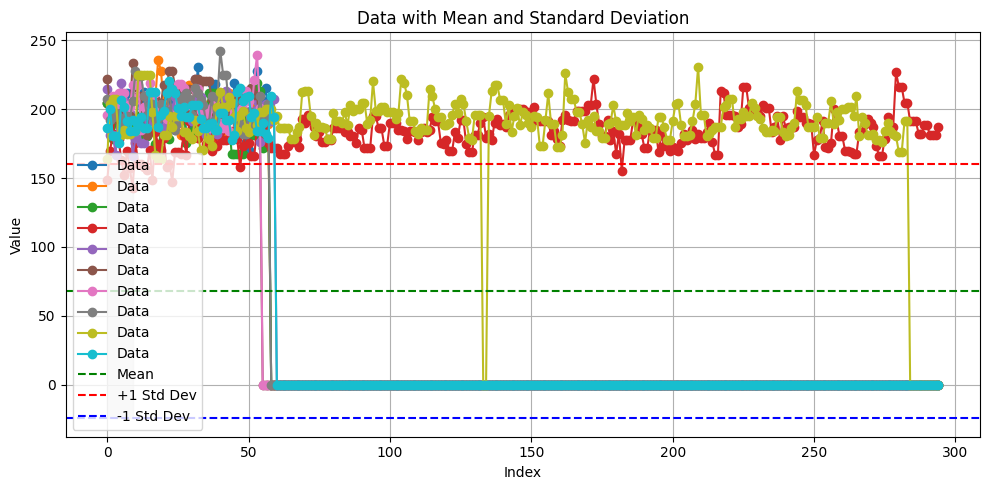

In [139]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation

data = X_train[:10, :295, 0]
#data[data == 0] = np.nan
mean = np.mean(data)
std_dev = np.std(data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data.T, marker='o', label='Data')
plt.axhline(mean, color='green', linestyle='--', label='Mean')
plt.axhline(mean + std_dev, color='red', linestyle='--', label='+1 Std Dev')
plt.axhline(mean - std_dev, color='blue', linestyle='--', label='-1 Std Dev')
plt.fill_between(range(len(data)), mean - std_dev, mean + std_dev, color='gray', alpha=0.2)

# Labels and legend
plt.title('Data with Mean and Standard Deviation')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Model

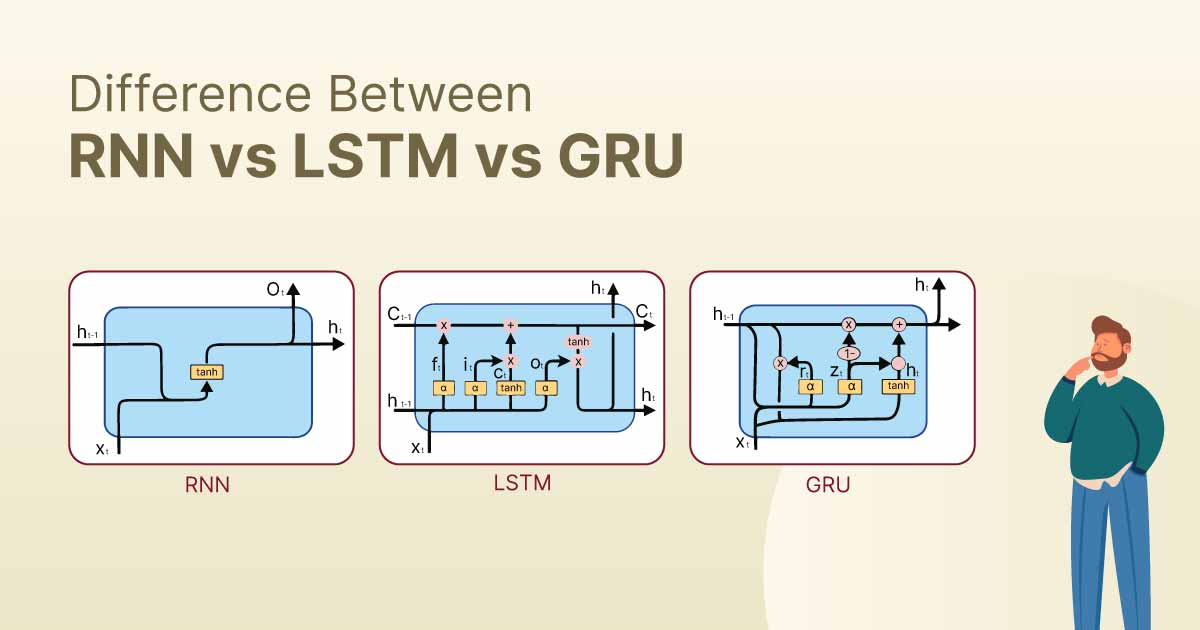

In [143]:
import tensorflow as tf
from xgboost import XGBRegressor

import random
import os

# 1. Set global seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

#model_type = 'GRU'
def build_model(model_type):
  if model_type == 'RNN' and not flatten:
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.SimpleRNN(64, return_sequences=True),
      tf.keras.layers.SimpleRNN(64, return_sequences=False),
      tf.keras.layers.Dense(1)
    ])
  elif model_type == 'LSTM' and not flatten:
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.LSTM(
          64,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      ),
      tf.keras.layers.Dense(
          1,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'GRU' and not flatten:
    print('Build GRU Model')
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.GRU(
          64,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      ),
      tf.keras.layers.Dense(
          1,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'BiGRU' and not flatten:
   model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.Bidirectional(
          tf.keras.layers.GRU(
              64,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
              recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
              bias_initializer=tf.keras.initializers.Zeros()
          )
      ),
      tf.keras.layers.Dense(
        1,
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
        bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'NN':
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(padded_features_np.shape[1], padded_features_np.shape[2])),  # shape: (timesteps, features)
      tf.keras.layers.Flatten(),  # flatten (timesteps, features) to (timesteps * features)
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
  elif model_type == 'XGBoost' and flatten:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

  print("Compile Model")
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

In [8]:
#from tensorflow.keras.utils import plot_model

#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

##Neural Ordinary Differential Equations (arXiv:1806.07366)

#Train

##Regresion

In [144]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',     # What metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

#tf.keras.backend.clear_session()

batch_s = 8
epochs_n = 50

training_sizes = [10, 30, 50, 70, 100]

gru_mae  = []
model = build_model('GRU')
print(type(model))
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  gru_mae.append(model.evaluate(X_test, y_test)[1])


lstm_mae  = []
model = build_model('LSTM')
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  lstm_mae.append(model.evaluate(X_test, y_test)[1])


bigru_mae  = []
model = build_model('BiGRU')
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  bigru_mae.append(model.evaluate(X_test, y_test)[1])

Build GRU Model
Compile Model
<class 'keras.src.models.sequential.Sequential'>
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - loss: 0.2547 - mae: 0.3805 - val_loss: 0.0533 - val_mae: 0.2307
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.2053 - mae: 0.3341 - val_loss: 0.0361 - val_mae: 0.1897
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1432 - mae: 0.2765 - val_loss: 0.0210 - val_mae: 0.1441
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0596 - mae: 0.1927 - val_loss: 0.0089 - val_mae: 0.0926
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 0.0152 - mae: 0.1083 - val_loss: 0.0016 - val_mae: 0.0386
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - loss: 0.0017 - mae: 0.0370 - val_loss: 0.0016 - val_mae: 0.0283
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: 0.0045 - mae: 0.0468 - val_loss: 0.0061 - val_mae: 0.0739
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0074 - mae: 0.0812 - val_loss: 0.0078 - val_mae: 

In [145]:
print(lstm_mae)
print(gru_mae)
print(bigru_mae)

[0.017235374078154564, 0.012183223851025105, 0.007900643162429333, 0.008005215786397457, 0.008061734028160572]
[0.011328734457492828, 0.007817056030035019, 0.00784476101398468, 0.00788932479918003, 0.00785029400140047]
[0.09771241992712021, 0.06969120353460312, 0.06823846697807312, 0.04757649824023247, 0.04527151212096214]


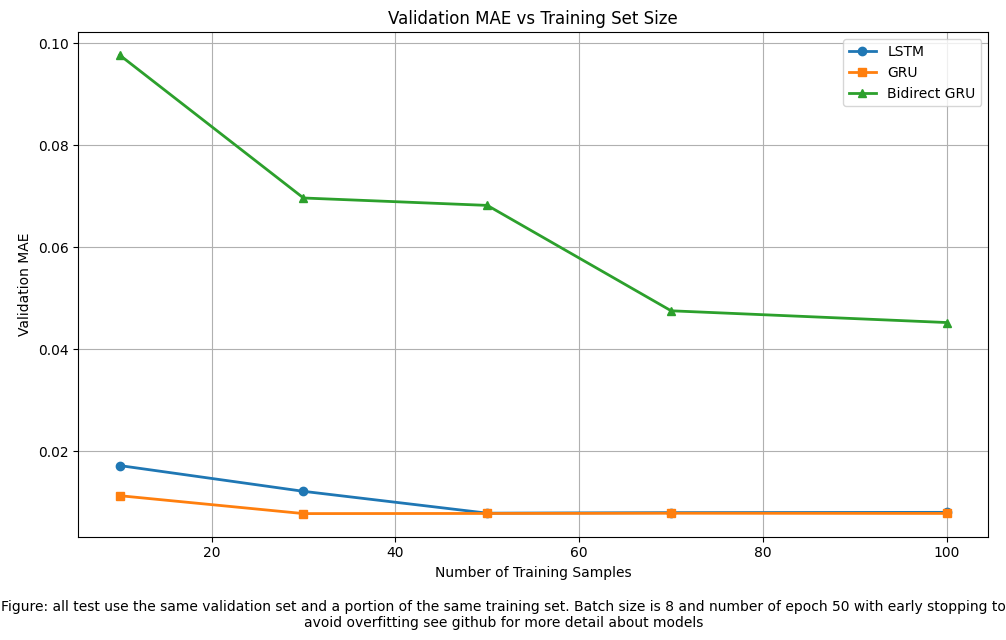

In [146]:
import matplotlib.pyplot as plt

# Example data (replace with your actual values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, lstm_mae, marker='o', label='LSTM', linewidth=2)
plt.plot(training_sizes, gru_mae, marker='s', label='GRU', linewidth=2)
plt.plot(training_sizes, bigru_mae, marker='^', label='Bidirect GRU', linewidth=2)

# Labels and title
plt.xlabel('Number of Training Samples')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs Training Set Size')
plt.legend()
plt.grid(True)


plt.figtext(0.5, -0.05,
            'Figure: all test use the same validation set and a portion of the same training set. Batch size is 8 and number of epoch 50 with early stopping to avoid overfitting see github for more detail about models',
            wrap=True, horizontalalignment='center', fontsize=10)


plt.tight_layout()

# Show plot
plt.show()


In [141]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',     # What metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

model = build_model('GRU')
#history = model.fit(X_train, y_train, epochs=75, batch_size=4, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
history = model.fit(X_train, y_train, epochs=75, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

#history = model.fit(X_train, y_train)

Build GRU Model
Compile Model
Epoch 1/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.2190 - mae: 0.2190 - val_loss: 0.0469 - val_mae: 0.0469
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0081 - val_mae: 0.0081
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 7/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0087 - val_mae: 0.0087
Epoch 8/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0094 - mae: 0.0094 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 9/75
13/13 ━━━━━━━━━

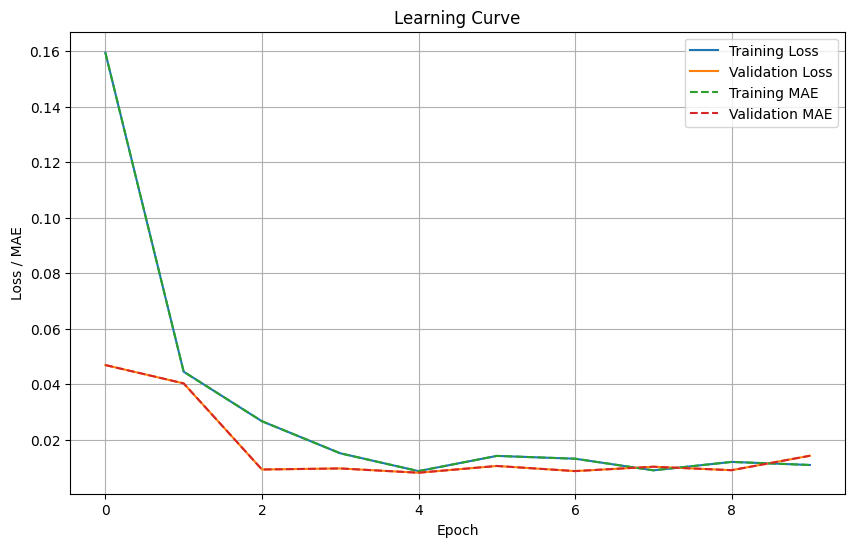

In [142]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Optional: plot additional metrics like MAE
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE', linestyle='--')
    plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend()
plt.grid(True)
plt.show()


#Evaluate

In [16]:
#For XGBoost
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

# Evaluate
mse = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Test MSE: 0.007421683054417372


In [17]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0074 - mae: 0.0074


[0.007421683054417372, 0.007421683054417372]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=./logs

Sequance A->B or B->A: \\
RNN: [0.04569952189922333, 0.1260969489812851] \\
LSTM: [0.006350232753902674, 0.05139995738863945] \\
GRU: [0.0006004805327393115, 0.016981273889541626] \\

Sequance A->B->A \\
RNN: [0.0014131211210042238, 0.03691475838422775] \\
LSTM: [0.00016026363300625235, 0.01250477135181427] \\
GRU: [7.255527634697501e-06, 0.002303078770637512]

##RNN (epoch: 75, batch size: 4):

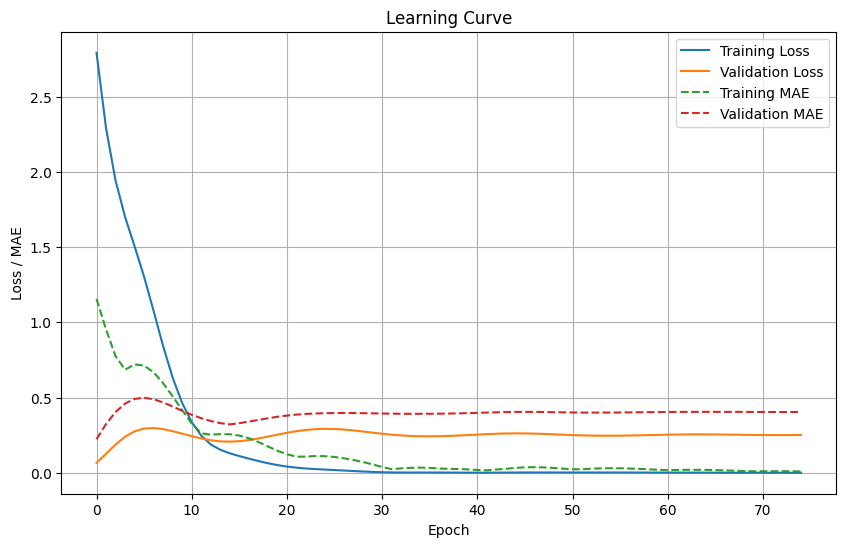

##LSTM (epoch: 75, batch size: 4)

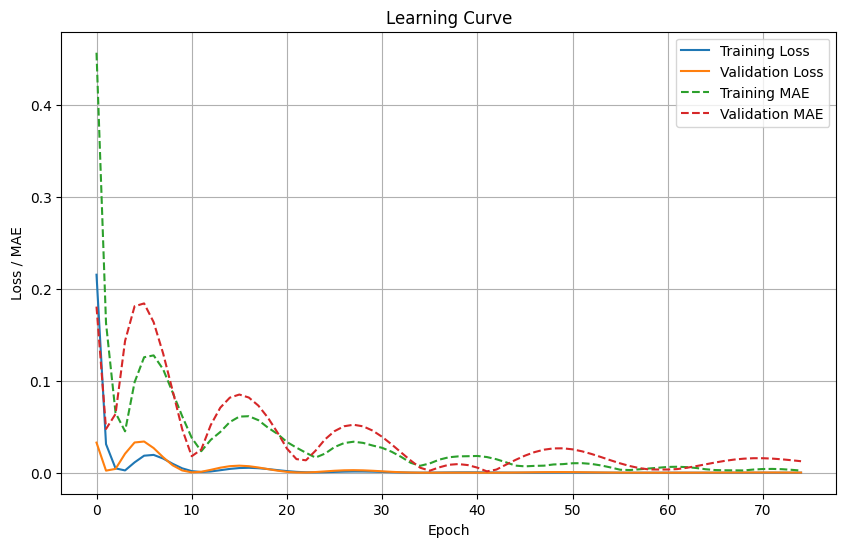

##GRU (ephoch: 75, batch size: 4)

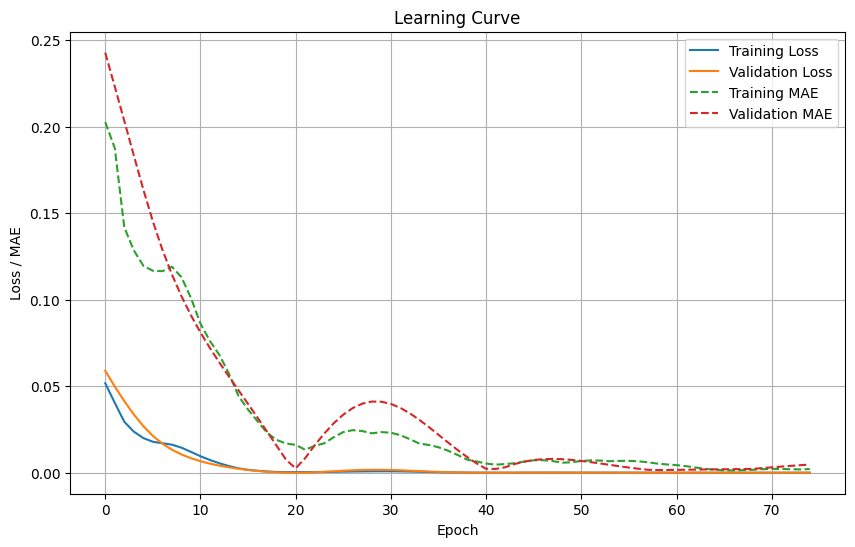